In [1]:
%pip install yfinance finta Jinja2 xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from tickerData import *
from mlAlgorithms import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = getTickerData(ticker="btc-usd", period="max", interval="1d")
df.drop(columns={'Adj Close'}, inplace=True)
df.rename(columns={'Date':'date', 'Open':'open', 'High':'high','Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)
df = exponential_smooth(df, 0.65)

[*********************100%***********************]  1 of 1 completed


In [4]:
#indicator_list = ""
#with open('indicators.txt', 'r') as indicators:
#    indicator_list = indicators.read().replace("'", '"')
#indicator_list = re.findall(r'"([^"]*)"', indicator_list)

In [5]:
indicators = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX', 'VAMA', 'ZLEMA', 'VWAP', 'PPO', 'ATR', 'DMI', 'PIVOT_FIB', 'CFI', 'WTO']
df = getTickerIndicatorData(df, indicators, dropna=True)

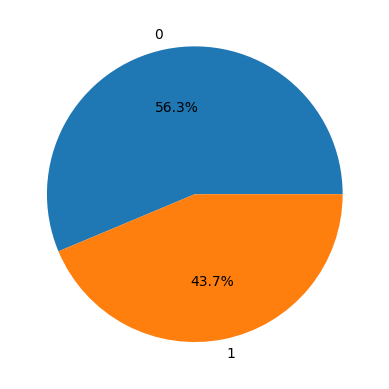

In [6]:
df = produce_prediction(df, 14, dropna=True, removeohl=True)
plt.pie(df['pred'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

In [7]:
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.70)]
df = df.drop(columns=to_drop)
df.corr().abs().style.background_gradient(cmap='coolwarm')

,close,14 period RSI,MACD,MOM,normVol,pred
close,1.000000,0.035895,0.156616,0.074743,0.020552,0.145317
14 period RSI,0.035895,1.000000,0.543806,0.524322,0.232482,0.112734
MACD,0.156616,0.543806,1.000000,0.658666,0.106829,0.035332
MOM,0.074743,0.524322,0.658666,1.000000,0.100035,0.039902
normVol,0.020552,0.232482,0.106829,0.100035,1.000000,0.036966
pred,0.145317,0.112734,0.035332,0.039902,0.036966,1.000000


In [8]:
features = StandardScaler().fit_transform(df[df.columns.difference(['pred', 'date'])])
target = df['pred']

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.4, shuffle=False)
X_train.shape

(1842, 5)

{'n_neighbors': 19}
              precision    recall  f1-score   support

         0.0       0.52      0.80      0.63       569
         1.0       0.68      0.37      0.48       659

    accuracy                           0.57      1228
   macro avg       0.60      0.59      0.56      1228
weighted avg       0.61      0.57      0.55      1228

KNN TEST SET - 0.5700325732899023
KNN TRAIN SET - 0.6748099891422367
{'C': 0.1, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.54      0.46      0.50       569
         1.0       0.59      0.66      0.62       659

    accuracy                           0.57      1228
   macro avg       0.57      0.56      0.56      1228
weighted avg       0.57      0.57      0.57      1228

LR TEST SET - 0.5708469055374593
LR TRAIN SET - 0.5836047774158524


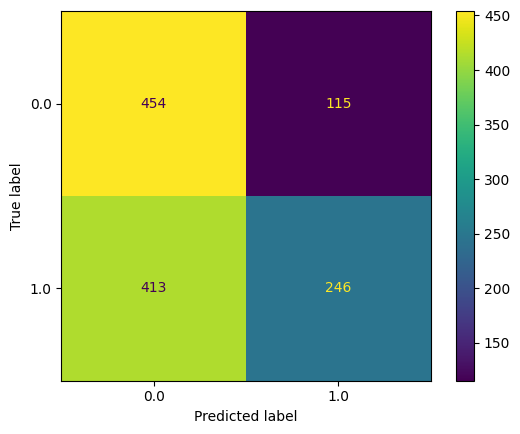

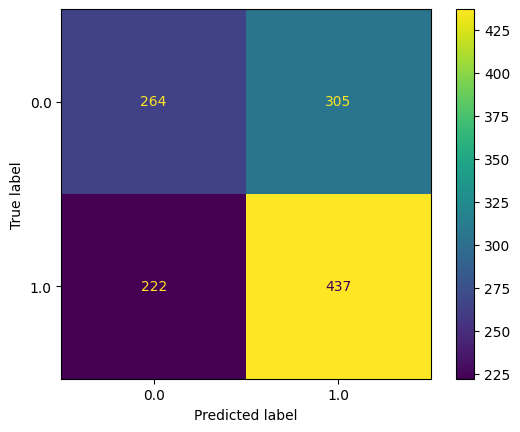

In [9]:
knn = trained_KNN(X_train, X_test, Y_train, Y_test)
lr = trained_LogisticRegression(X_train, X_test, Y_train, Y_test)
#rfc = trained_RandomForestClassifier(X_train, X_test, Y_train, Y_test)
vc = trained_VotingClassifier(lr, knn, X_train, X_test, Y_train, Y_test)